In [29]:
import numpy as np
import matplotlib.pylab as plt
import os, sys
from scipy import stats
sys.path.append(os.path.join('.', 'physion', 'src'))
from physion.analysis.read_NWB import Data
from physion.dataviz.raw import plot, find_default_plot_settings
from physion.dataviz.imaging import show_CaImaging_FOV
import plot_tools as pt

In [30]:
###################################################
###   Calcium Imaging Preprocessing Options #######
###################################################

dFoF_options = dict(
    method_for_F0='percentile',
    neuropil_correction_factor=0.7,
    percentile=5)


###################################################
###   Running/Stationary Period Analysis    #######
###################################################

def is_running(data,
               threshold=0.1,
               merging_window=0.5):
    # larger than threshold
    run = data.running_speed>threshold
    # merging nearby episodes
    for i in np.arange(len(data.t_dFoF))[run]:
        iNext = np.flatnonzero(run[i+1:])
        if len(iNext)>0 and\
            ((data.t_dFoF[i+iNext[0]]-\
                  data.t_dFoF[i])<merging_window):
            run[i+1:i+1+iNext[0]] = True

    return run

def is_stationary(data, run,
                  discard_pre=0.5,
                  discard_post=1.5):
    # not running
    stat = ~run
    # discard surrounding intervals
    for i in np.arange(len(data.t_dFoF))[stat]:
        # not in the post window
        iNext = np.flatnonzero(run[i+1:])
        if len(iNext)>0 and\
            ((data.t_dFoF[i+iNext[0]]-\
                  data.t_dFoF[i])<discard_pre):
            stat[i:i+1+iNext[0]] = False
        # not in the pre window
        iPrev = np.flatnonzero(run[:i+1][::-1])
        if len(iPrev)>0 and\
            ((data.t_dFoF[i]-\
                  data.t_dFoF[i-iPrev[0]])<discard_post):
            stat[i-iPrev[0]:i] = False

    return stat

def lmi(data, roi, rest, run):
    """ Locomotion Modulation Index """
    return np.clip((np.mean(data.dFoF[roi,run])-np.mean(data.dFoF[roi,rest]))/\
        (np.mean(data.dFoF[roi,run])+np.mean(data.dFoF[roi,rest])), -1, 1)

def analyze_bouts(data, dFoF_options):
    """
    compute:
    - dFoF during rest
    - dFoF during run
    - LMI
    """
    if not hasattr(data, 'dFoF'):
        data.build_dFoF(**dFoF_options, verbose=False)
    if not hasattr(data, 'running_speed'):
        data.running_speed = data.build_running_speed(specific_time_sampling=data.t_dFoF)
    # set 
    run = is_running(data)
    rest = is_stationary(data, run)
    return [np.mean(data.dFoF[roi,rest]) for roi in np.arange(data.nROIs)],\
           [np.mean(data.dFoF[roi,run]) for roi in np.arange(data.nROIs)],\
           [lmi(data, roi, rest, run) for roi in np.arange(data.nROIs)]

In [31]:
#root_folder = os.path.join(os.path.expanduser('~'), 'DATA', 'SST-Revision')
root_folder = os.path.join('.', 'data')
ctrls = [os.path.join(root_folder, 'ctrl', f) for f in np.sort(os.listdir(os.path.join(root_folder, 'ctrl'))) if 'nwb' in f]
tests = [os.path.join(root_folder, 'test', f) for f in np.sort(os.listdir(os.path.join(root_folder, 'test'))) if 'nwb' in f]


calculating dF/F with method "percentile" [...]

  ** 1 ROIs were discarded with the positive F0 criterion (2.7%) ** 

-> dFoF calculus done !  (calculation took 0.0s)


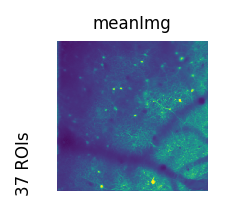

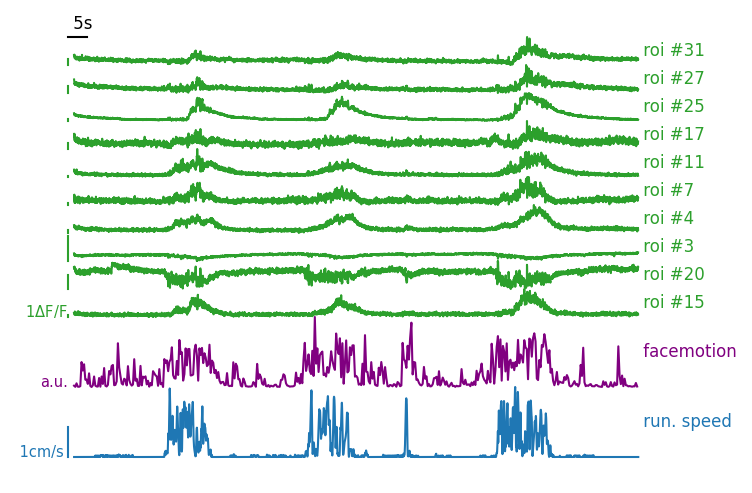

In [32]:
filename = ctrls[4]
data = Data(filename, verbose=False)
fig, _, _ = show_CaImaging_FOV(data, NL=3)
settings = {
 'Locomotion': {'fig_fraction': 0.11764705882352941,
  'subsampling': 1,
  'color': '#1f77b4',
  'fig_fraction_start': 0.058823529411764705},
 'FaceMotion': {'fig_fraction': 0.11764705882352941,
  'subsampling': 10,
  'color': 'purple',
  'fig_fraction_start': 0.1764705882352941},
 'CaImaging': {'fig_fraction': 0.47058823529411764,
  'subsampling': 1,
  'subquantity': 'dFoF',
  'color': '#2ca02c',
  'roiIndices': np.array([14, 19, 2, 3, 6, 10, 16, 24, 26, 30]),
  'fig_fraction_start': 0.2941176470588235}}
data.build_dFoF(**dFoF_options)
running_speed = data.build_running_speed(specific_time_sampling=data.t_dFoF)
fig, AX = plot(data, [0, 2.5*60], settings, ax=plt.subplots(1, figsize=(5,4))[1])
plt.savefig('/Users/yann/Desktop/temp.svg')


calculating dF/F with method "percentile" [...]

  ** all ROIs passed the positive F0 criterion ** 

-> dFoF calculus done !  (calculation took 0.0s)


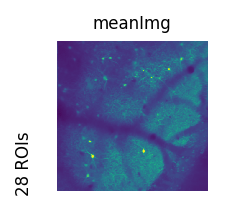

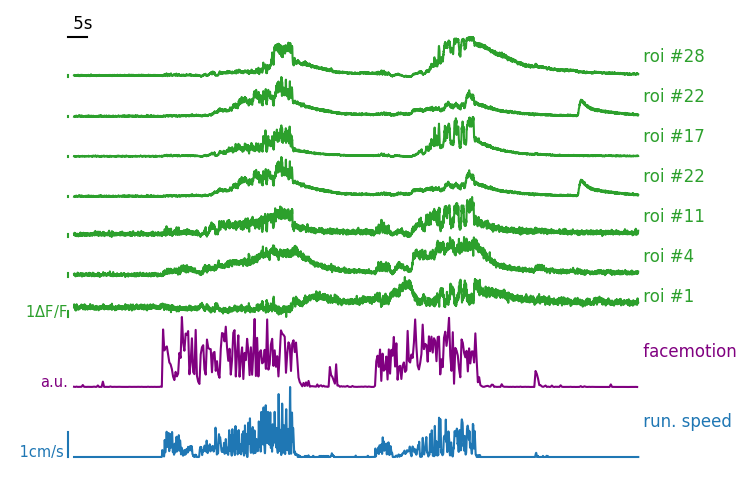

In [33]:
filename = tests[4]
data = Data(filename, verbose=False)
fig, _, _ = show_CaImaging_FOV(data, NL=3)
settings = {
 'Locomotion': {'fig_fraction': 0.11764705882352941,
  'subsampling': 1,
  'color': '#1f77b4',
  'fig_fraction_start': 0.058823529411764705},
 'FaceMotion': {'fig_fraction': 0.11764705882352941,
  'subsampling': 10,
  'color': 'purple',
  'fig_fraction_start': 0.1764705882352941},
 'CaImaging': {'fig_fraction': 0.47058823529411764,
  'subsampling': 1,
  'subquantity': 'dFoF',
  'color': '#2ca02c',
  'roiIndices': np.array([0, 3, 10, 21, 16, 21, 27]),
  'fig_fraction_start': 0.2941176470588235}}
data.build_dFoF(**dFoF_options)
running_speed = data.build_running_speed(specific_time_sampling=data.t_dFoF)
t0 = 1.9*60
fig, AX = plot(data, [t0, t0+2.5*60], settings, ax=plt.subplots(1, figsize=(5,4))[1])
#plt.savefig('/Users/yann/Desktop/temp.svg')

NWB-file reading time: 94.6ms


(<Figure size 255x195 with 1 Axes>,
 <Axes: title={'center': 'meanImg'}>,
 <matplotlib.image.AxesImage at 0x2bc1d7710>)

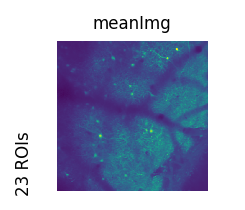

In [55]:
from physion.dataviz.imaging import show_CaImaging_FOV
data = Data(tests[3])
show_CaImaging_FOV(data, NL=3)

NWB-file reading time: 84.5ms


(None, <Axes: >)

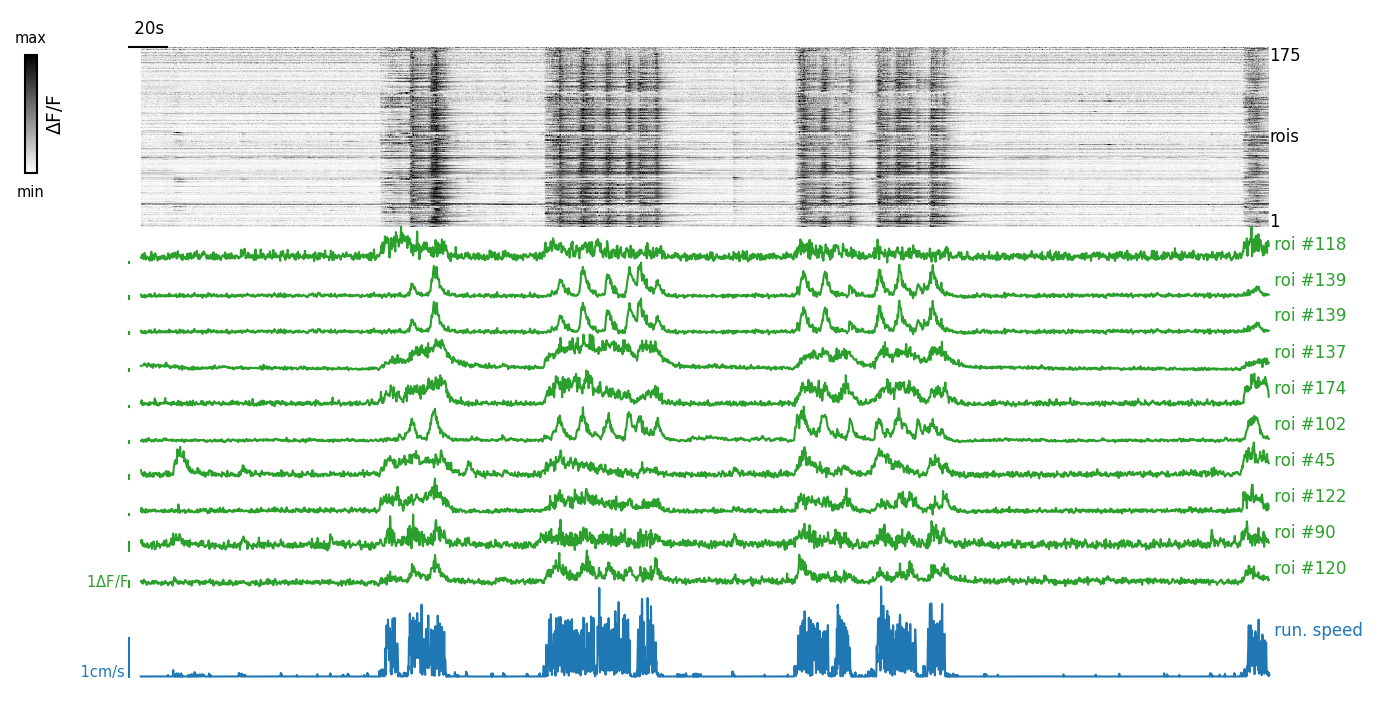

In [35]:
data = Data(ctrls[0])
data.build_dFoF(**dFoF_options, verbose=False)
data.build_running_speed(verbose=False)
plot_settings = dict(Locomotion={'fig_fraction': 1, 'color': '#1f77b4'},
                     CaImaging={'fig_fraction': 4, 'subquantity': 'dF/F', 'color': '#2ca02c', 
                                'roiIndices':np.random.choice(np.arange(data.nROIs),10)},
                     CaImagingRaster={'fig_fraction': 2, 'roiIndices': 'all',
                                      'normalization': 'per-line', 'subquantity': 'dF/F'})

fig, ax = plt.subplots(1, figsize=(10,6))
plot(data, [0*60, 10*60], plot_settings, ax=ax)

NWB-file reading time: 149.2ms

calculating dF/F with method "percentile" [...]

  ** 16 ROIs were discarded with the positive F0 criterion (10.0%) ** 

-> dFoF calculus done !  (calculation took 0.0s)


(None, <Axes: >)

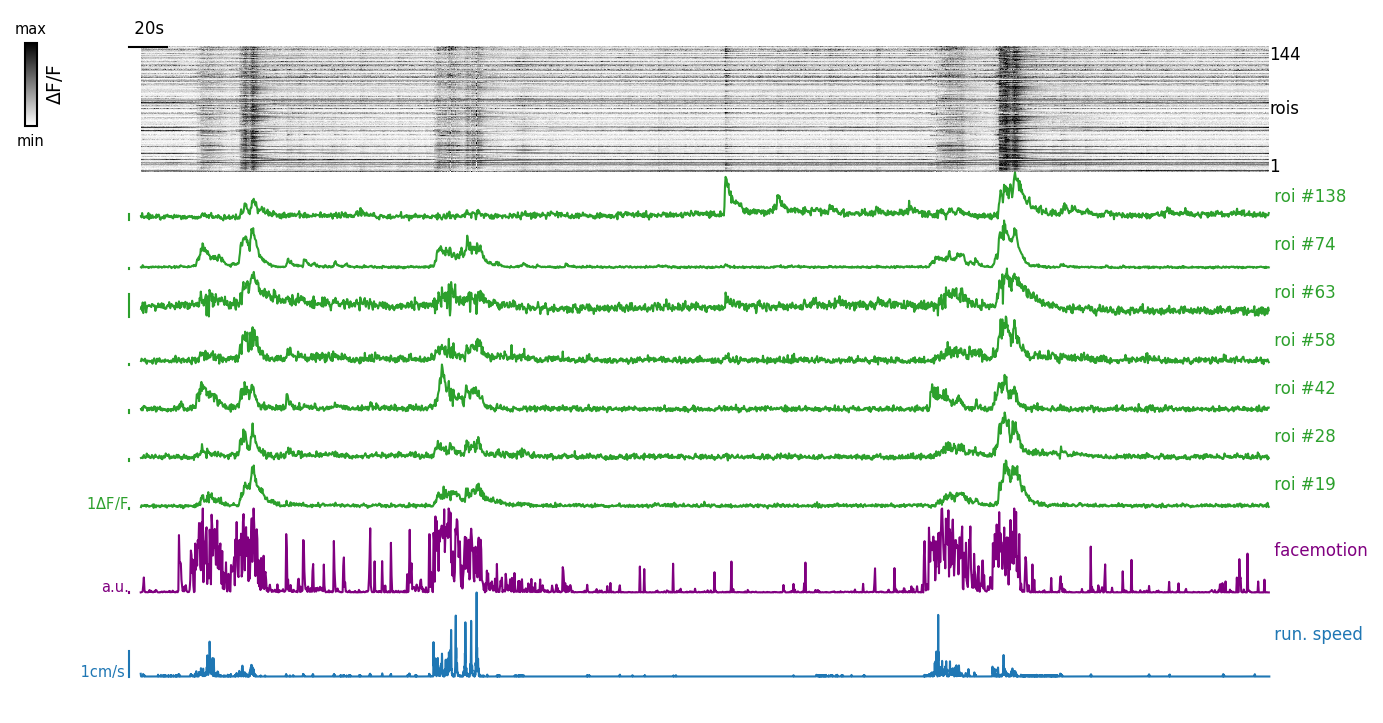

In [36]:
data = Data(tests[0])
data.build_dFoF(**dFoF_options)
running_speed = data.build_running_speed(specific_time_sampling=data.t_dFoF)
settings = find_default_plot_settings(data)
#settings['CaImaging']['roiIndices'] = [110,155,14,33,42,121,87,200,88,119]#+list(np.random.choice(np.arange(data.vNrois), 2, replace=False))
settings['CaImaging']['subquantity'] = 'dFoF'
settings['CaImagingRaster']['fig_fraction'] = 1.5
settings['CaImagingRaster']['subquantity'] = 'dFoF'
plot(data, [0, 10*60], settings, ax=plt.subplots(1, figsize=(10,6))[1])

## Analysis of LMI per ROIs

Ctrl (n=578): 0.200$\pm$0.016
CNO (n=362): 0.198$\pm$0.018


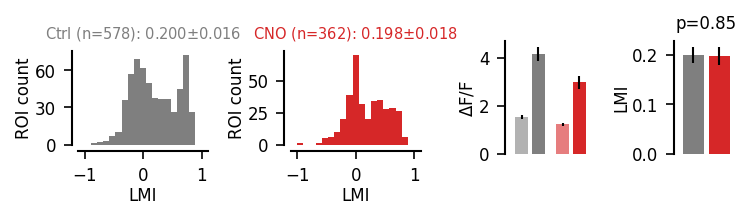

In [44]:
fig, AX = pt.figure(axes=(2, 1), right=20)

inset = pt.inset(AX[1], [1.7,-0.1,0.6,1.2])
inset2 = pt.inset(AX[1], [3.,-0.1,0.4,1.2])

Rest, Run, LMI = {}, {}, {}
for ax, case, label, color in zip(AX,
                                  [ctrls, tests],
                                  ['Ctrl', 'CNO'],
                                  ['tab:grey', 'tab:red']):

    
    Rest[label], Run[label], LMI[label] = [], [], []
    for fn in case:
        data = Data(fn, verbose=False)
        restFs, runFs, LMIs = analyze_bouts(data, dFoF_options)
        Rest[label]+=restFs
        Run[label]+=runFs
        LMI[label]+=LMIs

    i0 = 0 if label=='Ctrl' else 2.5
    inset.bar([i0], [np.mean(Rest[label])], yerr=[stats.sem(Rest[label])], color=color, width=.8, alpha=.6)
    inset.bar([i0+1], [np.mean(Run[label])], yerr=[stats.sem(Run[label])], color=color, width=.8)
    inset2.bar([i0], [np.mean(LMI[label])], yerr=[stats.sem(LMI[label])], color=color, width=2.)

    ax.hist(LMI[label], bins=np.linspace(-1, 1, 20), color=color)

    pt.set_plot(ax,
                xlabel='LMI',
                xticks=[-1,0,1],
                ylabel='ROI count')
    print('%s (n=%i): %.3f$\pm$%.3f' % (label, len(LMI[label]), np.mean(LMI[label]), stats.sem(LMI[label])))
    ax.set_title('%s (n=%i): %.3f$\pm$%.3f' % (label, len(LMI[label]),
                                               np.mean(LMI[label]), stats.sem(LMI[label])),
                 color=color, fontsize=7)

pt.set_plot(inset, ['left'], ylabel='$\Delta$F/F')
pt.set_plot(inset2, ['left'], ylabel='LMI', yticks=[0,0.1,0.2],
            title='p=%.2f' % stats.mannwhitneyu(LMI['Ctrl'], LMI['CNO']).pvalue)
#plt.savefig('/Users/yann/Desktop/temp.svg')

## Analysis of LMI per session

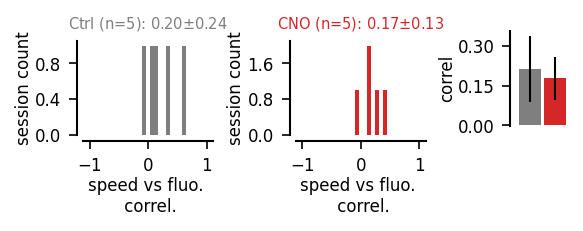

In [18]:
fig, AX = pt.figure(axes=(2, 1), right=6)

LMI = {}
for ax, case, label, color in zip(AX,
                                  [ctrls, tests],
                                  ['Ctrl', 'CNO'],
                                  ['tab:grey', 'tab:red']):

    LMI[label] = []
    for fn in case:
        data = Data(fn, verbose=False)
        _, _, LMIs = analyze_bouts(data, dFoF_options)
        LMI[label].append(np.mean(LMIs))

    ax.hist(LMI[label], bins=np.linspace(-1, 1, 30), color=color)

    pt.set_plot(ax,
                xlabel='speed vs fluo. \n correl.',
                xticks=[-1,0,1],
                ylabel='session count')
    ax.set_title('%s (n=%i): %.2f$\pm$%.2f' % (label, len(CC[label]),
                                               np.mean(CC[label]), np.std(CC[label])),
                 color=color, fontsize=7)

inset = pt.inset(AX[1], [1.7,0.1,0.4,1])
pt.bar([np.mean(LMI['Ctrl']), np.mean(LMI['CNO'])],
       #sy=[np.std(CC['Ctrl']), np.std(CC['CNO'])],
       sy=[stats.sem(LMI['Ctrl']), stats.sem(LMI['CNO'])],
       COLORS=['tab:grey', 'tab:red'], ax=inset)
pt.set_plot(inset, ['left'], ylabel='correl')